# Unsupervised Segmentation of DAPI dataset

This notebook shows the iamge pre-processing steps to create a dataloader which can be used for training.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import genus as gn
import numpy
from genus.util_data import  DataloaderWithLoad, ConditionalRandomCrop, DatasetInMemory
from genus.util import linear_interpolation, append_to_dict, ckpt2file, load_obj
from genus.util_vis import show_batch
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from functools import partial

### Read the config file 

In [4]:
dataset_file = "/Users/ldalessi/REPOS/genus/notebooks/example_data/DAPI/dapi_downsampled.tif"
#config_file = "/Users/ldalessi/REPOS/genus/notebooks/config_dapi.json"
#config = load_json_as_dict(config_file)

### Open and Visualize the input image

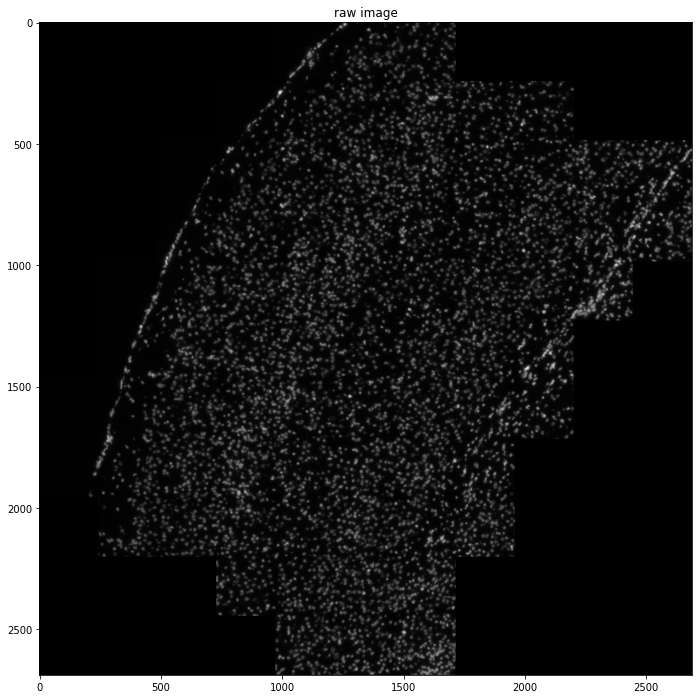

In [5]:
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None

pilfile = PIL.Image.open(dataset_file)
img_np = numpy.array(pilfile)

fig, axs = plt.subplots(ncols=1, figsize=(12,12))
axs.imshow(img_np, cmap='gray')
_ = axs.set_title("raw image")

### Obtain the Region of Interest (ROI) by simple thresholding

This image was collected by tiling a biological tissue with multiple Field of Views (FOVs). Therefore the Region of Interest has an irregular shape.

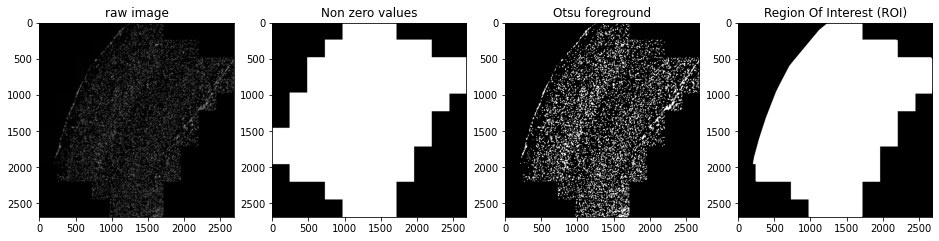

In [6]:
import skimage.filters
import skimage.morphology

image_thresh = skimage.filters.threshold_otsu(img_np)
roi_mask_np = skimage.morphology.convex_hull_image((img_np > image_thresh)) * (img_np > 1E-5)

fig, axs = plt.subplots(ncols=4, figsize=(16,16))
axs[0].imshow(img_np, cmap='gray')
axs[1].imshow(img_np > 0.0, cmap='gray')
axs[2].imshow(img_np > image_thresh, cmap='gray')
axs[3].imshow(roi_mask_np, cmap='gray')
_ = axs[0].set_title("raw image")
_ = axs[1].set_title("Non zero values")
_ = axs[2].set_title("Otsu foreground")
_ = axs[3].set_title("Region Of Interest (ROI)")

### Do some contrast enhancement

In [22]:
# Compute the quantile based on the Otsu foreground component
ql, qr = numpy.percentile(img_np[img_np > image_thresh].flatten(), q=(0, 100))  

# Rescale the intensities in (0,1)
img_np_rescaled = skimage.exposure.rescale_intensity(img_np, in_range=(ql, qr), out_range=(0.0, 1.0)) 

# Do intensity equalization
img_np_enhanced = skimage.exposure.equalize_adapthist(img_np_rescaled, kernel_size=160, clip_limit=0.03)

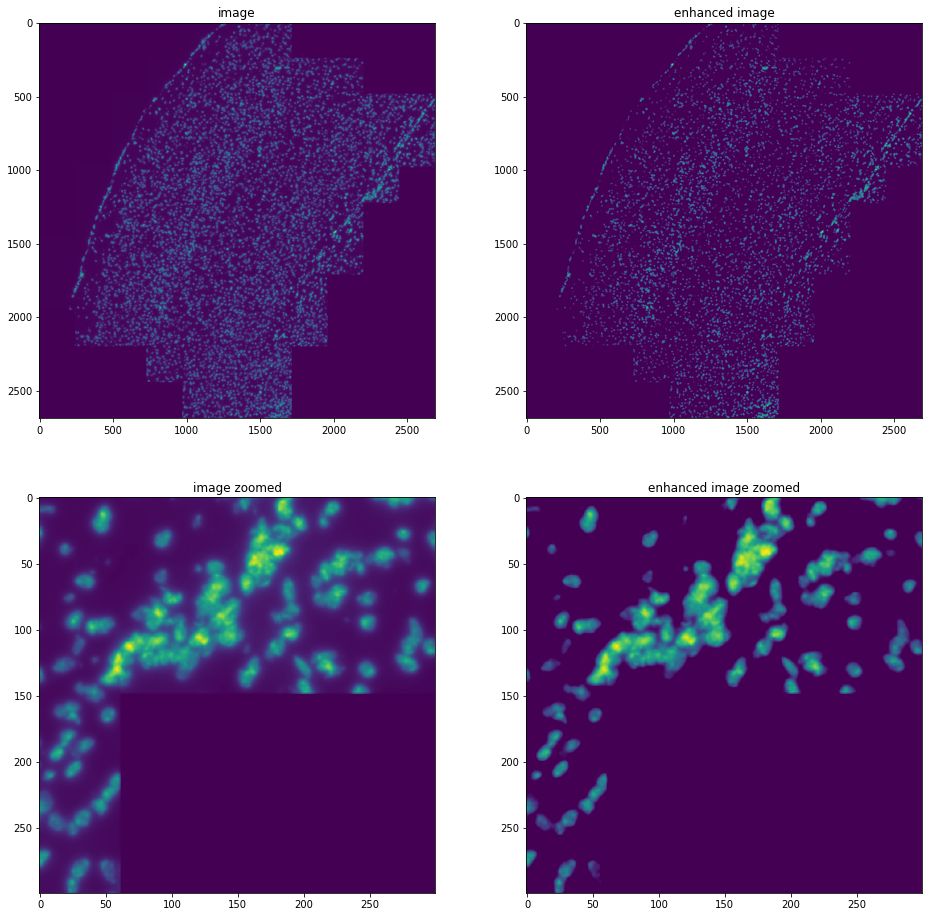

In [8]:
ix, iy, delta = 1080, 2140, 300
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16,16))
axs[0,0].imshow(img_np)
axs[0,1].imshow(img_np_enhanced)
axs[1,0].imshow(img_np[ix:ix+delta,iy:iy+delta])
axs[1,1].imshow(img_np_enhanced[ix:ix+delta,iy:iy+delta])

_ = axs[0,0].set_title("image")
_ = axs[0,1].set_title("enhanced image")
_ = axs[1,0].set_title("image zoomed")
_ = axs[1,1].set_title("enhanced image zoomed")

### Create the dataset 

In [30]:
img_torch = torch.from_numpy(img_np_enhanced)[None,None].float()
roi_mask_torch = torch.from_numpy(roi_mask_np)[None,None].bool()

In [32]:
BATCH_SIZE = 256
CROP_SIZE = 80
N_TEST = 3*BATCH_SIZE
N_TRAIN = BATCH_SIZE

conditional_crop_test = ConditionalRandomCrop(size=CROP_SIZE, n_crops_per_image=N_TEST, min_roi_fraction=0.9)
conditional_crop_train = ConditionalRandomCrop(size=CROP_SIZE, n_crops_per_image=N_TRAIN, min_roi_fraction=0.9)

In [33]:
# The test_dataset is built creating N_TEST random crops from the image
test_dataset = DatasetInMemory(x=conditional_crop_test(img=img_torch, roi_mask=roi_mask_torch))

print("test_dataset shape ->",test_dataset.x.shape)

test_dataset shape -> torch.Size([768, 1, 80, 80])


In [34]:
# The train_dataset consist of a single large image. During training random crops will be generated on the fly
train_dataset = DatasetInMemory(x=img_torch,
                                x_roi=roi_mask_torch,
                                x_transform=conditional_crop_train)
# the single (large) image in the dataset replicated N_TRAIN times (without memory footprint)
# to keep indexing consistent.
print("train_dataset shape ->",train_dataset.x.shape)  

train_dataset shape -> torch.Size([256, 1, 2688, 2688])


### Create the dataloader as usual

In [35]:
test_loader = DataloaderWithLoad(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataloaderWithLoad(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

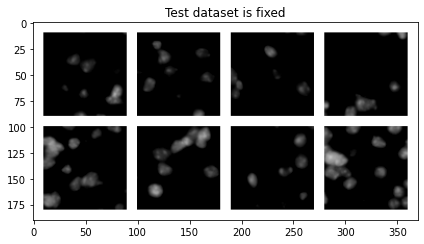

In [36]:
img, y, index = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test dataset is fixed")

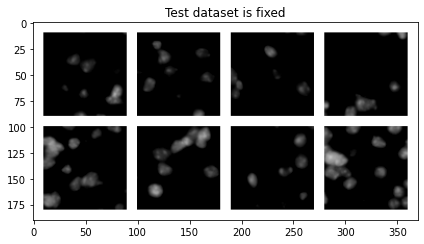

In [37]:
img, y, index = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test dataset is fixed")

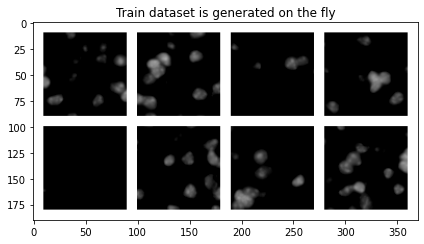

In [38]:
img, y, index = train_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Train dataset is generated on the fly")

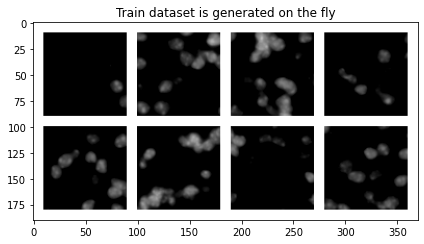

In [39]:
img, y, index = train_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Train dataset is generated on the fly")